# Import Dependencies

We begin by importing the necessary libraries.

In [1]:
# System & OS
import os

# Data analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# ML
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import graphviz
sns.set()
sns.set_style('white')
sns.set_palette('deep')

# Reproducibility

Set the seed to ensure our results are reproducible.

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 11
set_seed(SEED)

# Data Cleaning

Read in the [NHANES dataset](https://cran.r-project.org/web/packages/NHANES/NHANES.pdf), which contains a series of health and nutrition survey data collected by the US National Center for Health Statistics (NCHS). Note, a separate R script was used to export the data into a CSV file.

In [3]:
# Read data & drop irrelevant columns
df = pd.read_csv('../data/nhanes_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# Display results
df.head()

,ID,SurveyYr,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Length,HeadCirc,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysPhysHlthBad,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,TVHrsDayChild,CompHrsDayChild,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,51624,2009_10,male,34,30-39,409.0,White,NaN,High School,Married,25000-34999,30000.0,1.36,6.0,Own,NotWorking,87.4,NaN,NaN,164.7,32.22,NaN,30.0_plus,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,NaN,1.29,3.49,352.0,NaN,NaN,NaN,No,NaN,Good,0.0,15.0,Most,Several,NaN,NaN,NaN,4.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,0.0,No,Yes,Smoker,18.0,Yes,17.0,No,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN
1,51624,2009_10,male,34,30-39,409.0,White,NaN,High School,Married,25000-34999,30000.0,1.36,6.0,Own,NotWorking,87.4,NaN,NaN,164.7,32.22,NaN,30.0_plus,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,NaN,1.29,3.49,352.0,NaN,NaN,NaN,No,NaN,Good,0.0,15.0,Most,Several,NaN,NaN,NaN,4.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,0.0,No,Yes,Smoker,18.0,Yes,17.0,No,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN
2,51624,2009_10,male,34,30-39,409.0,White,NaN,High School,Married,25000-34999,30000.0,1.36,6.0,Own,NotWorking,87.4,NaN,NaN,164.7,32.22,NaN,30.0_plus,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,NaN,1.29,3.49,352.0,NaN,NaN,NaN,No,NaN,Good,0.0,15.0,Most,Several,NaN,NaN,NaN,4.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,0.0,No,Yes,Smoker,18.0,Yes,17.0,No,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN
3,51625,2009_10,male,4,0-9,49.0,Other,NaN,NaN,NaN,20000-24999,22500.0,1.07,9.0,Own,NaN,17.0,NaN,NaN,105.4,15.30,NaN,12.0_18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51630,2009_10,female,49,40-49,596.0,White,NaN,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,Rent,NotWorking,86.7,NaN,NaN,168.4,30.57,NaN,30.0_plus,86.0,112.0,75.0,118.0,82.0,108.0,74.0,116.0,76.0,NaN,1.16,6.70,77.0,0.094,NaN,NaN,No,NaN,Good,0.0,10.0,Several,Several,2.0,2.0,27.0,8.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,2.0,20.0,Yes,Yes,Smoker,38.0,Yes,18.0,No,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN


Then, we remove the rows corresponding to individuals under 16 yrs old, since our target `SleepTrouble` is only reported for individuals above 16. Further, we'll restrict our feature considerations to only the health variables in the dataframe, with the goal of identifying any links between an individual's health and their quality of sleep. 

In [4]:
# Filter under-16 individuals
df = df[df['Age'] >= 16]
# Only consider health variables
df = df.iloc[:, 33:51]

# Feature Engineering

Create a new feature `AvgUrineFlow` that describes the average urine flow rate (in mL/min) of an individual across (a max of) 2 trials. Note, missing values are omitted from our calculation of averages. 

In [5]:
# Calculate average urine flow rate
df['AvgUrineFlow'] = np.where(df['UrineFlow1'].isnull() & df['UrineFlow2'].isnull(), np.nan,
                        np.where(df['UrineFlow1'].isnull(), df['UrineFlow2'],
                            np.where(df['UrineFlow2'].isnull(), df['UrineFlow1'],
                                (df['UrineFlow1'] + df['UrineFlow2']) / 2
                                    )
                                )
                             )

Based on the available data, we identify the following features-of-interest that may serve as useful predictors for the target variable `SleepTrouble`:

- `TotChol`: total HDL cholesterol (in mmol/L)
- `Diabetes`: whether the participant has been told by a doctor/health professional that they have diabetes (Yes, No)
- `HealthGen`: self-reported rating of participant’s health in general (Excellent, Vgood, Good, Fair, or Poor)

and of course, our newly engineered feature `AvgUrineFlow`.

In [6]:
# Retain only the variables-of-interest
df = df[['TotChol', 'AvgUrineFlow', 'Diabetes', 'HealthGen', 'SleepTrouble']]

# Categorical Variables

Address the categorical variables by applying ordinal or one-hot encoding where appropriate.

In [7]:
# One-hot encoding
df['SleepTrouble'] = df['SleepTrouble'].map({'No': 0, 'Yes': 1})
df['Diabetes'] = df['Diabetes'].map({'No': 0, 'Yes': 1})
# Ordinal encoding
df['HealthGen'] = df['HealthGen'].map({'Poor': 1, 'Fair': 2, 'Good': 3, 'Vgood': 4, 'Excellent': 5})

# Handle Missing Values

Next, we need to process the missing values in the data.

In [8]:
# Print concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7773 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotChol       7346 non-null   float64
 1   AvgUrineFlow  7290 non-null   float64
 2   Diabetes      7771 non-null   float64
 3   HealthGen     6985 non-null   float64
 4   SleepTrouble  7772 non-null   float64
dtypes: float64(5)
memory usage: 364.4 KB


In [9]:
# Print percentage of missing values in each column
def check_nan(df):
    print(f'Percentage of missing values:\n\n{round(df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100, 2)}')
    
check_nan(df)

Percentage of missing values:

HealthGen       10.14
AvgUrineFlow     6.21
TotChol          5.49
Diabetes         0.03
SleepTrouble     0.01
dtype: float64


Since the percentage of missing values in `SleepTrouble` and `Diabetes` are so low, we'll impute them by assuming the participants have no such issues with sleep or diabetes, respectively.

In [10]:
# Impute missing values with 0
df['SleepTrouble'].fillna(value=0, inplace=True)
df['Diabetes'].fillna(value=0, inplace=True)

Further, based on the distributions of `TotChol` and `AvgUrineFlow`, we'll impute `NaN` values using the mean and median values, respectively.

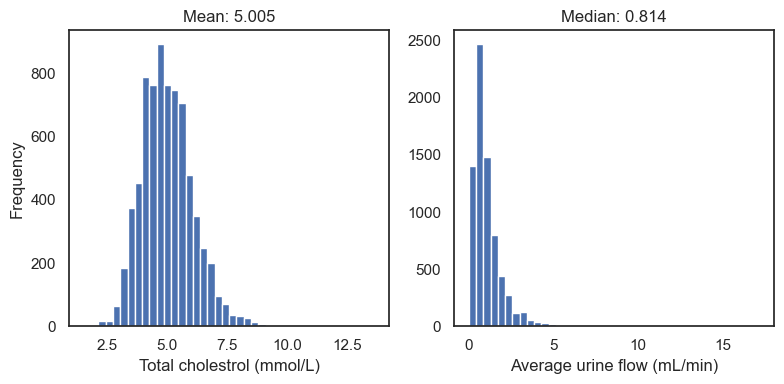

In [11]:
# Visualize distribution of quantitative variables
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
df['TotChol'].plot(kind='hist', bins=40, ax=ax[0])
df['AvgUrineFlow'].plot(kind='hist', bins=40, ax=ax[1])
ax[0].set_title(f'Mean: {df["TotChol"].mean():.3f}')
ax[1].set_title(f'Median: {df["AvgUrineFlow"].median():.3f}')
ax[0].set_xlabel('Total cholestrol (mmol/L)')
ax[1].set_xlabel('Average urine flow (mL/min)')
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

In [12]:
# Impute missing values with mean
df['TotChol'] = df['TotChol'].fillna(value=df['TotChol'].mean())
# Impute missing values with median
df['AvgUrineFlow'] = df['AvgUrineFlow'].fillna(value=df['AvgUrineFlow'].median())

Finally, since over a tenth of the values in `HealthGen` are missing, with no clear and obvious imputation scheme, we elect to simply drop the rows containing `NaN` values. 

In [13]:
# Drop rows with missing values
df.dropna(subset=['HealthGen'], inplace=True)
# Reset index
df.reset_index(drop=True, inplace=True)

# Exploratory Data Analysis (EDA)

We won't spend too much time on EDA since it isn't the focus of the assignment, but let's quickly generate some effective visualizations to better understand the data.

In [14]:
df.describe()

,TotChol,AvgUrineFlow,Diabetes,HealthGen,SleepTrouble
count,6985.000000,6985.000000,6985.000000,6985.000000,6985.000000
mean,5.015618,1.076476,0.099928,3.365784,0.254402
std,1.054647,0.931002,0.299926,0.947084,0.435556
min,1.530000,0.000000,0.000000,1.000000,0.000000
25%,4.270000,0.513000,0.000000,3.000000,0.000000
50%,5.005287,0.814000,0.000000,3.000000,0.000000
75%,5.610000,1.313000,0.000000,4.000000,1.000000
max,13.650000,13.692000,1.000000,5.000000,1.000000


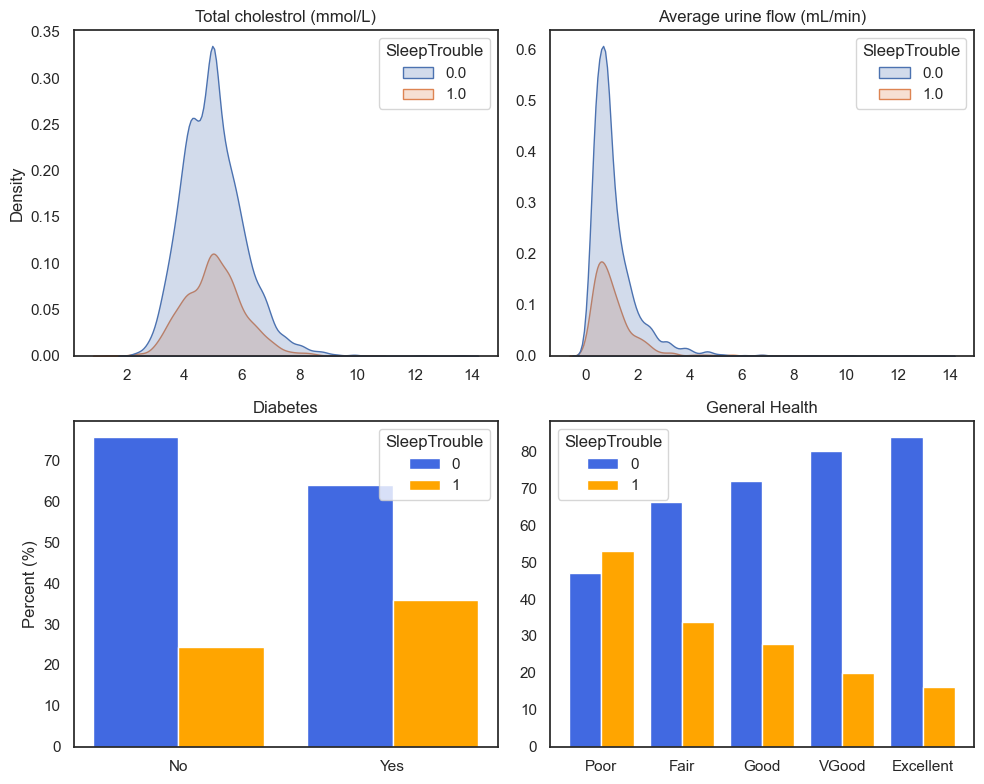

In [15]:
# Create figure and axes objects
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

# Visualize distribution of quantitative variables
sns.kdeplot(data=df, x='TotChol', hue='SleepTrouble', fill=True, ax=ax[0])
sns.kdeplot(data=df, x='AvgUrineFlow', hue='SleepTrouble', fill=True, ax=ax[1])

# Visualize distribution of discrete variables
percentages = {'Diabetes': df.groupby(['Diabetes', 'SleepTrouble']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1), 
               'HealthGen': df.groupby(['HealthGen', 'SleepTrouble']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)}
bar_width = 0.4
ax[2].bar(percentages['Diabetes'].index - bar_width/2, percentages['Diabetes'][0], width=bar_width, color='royalblue', label='0')
ax[2].bar(percentages['Diabetes'].index + bar_width/2, percentages['Diabetes'][1], width=bar_width, color='orange', label='1')
ax[3].bar(percentages['HealthGen'].index - bar_width/2, percentages['HealthGen'][0], width=bar_width, color='royalblue', label='0')
ax[3].bar(percentages['HealthGen'].index + bar_width/2, percentages['HealthGen'][1], width=bar_width, color='orange', label='1')

# Customize plots
ax[0].set_title(f'Total cholestrol (mmol/L)')
ax[1].set_title(f'Average urine flow (mL/min)')
ax[2].set_title('Diabetes')
ax[3].set_title('General Health')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

ax[1].set_ylabel('')
ax[2].set_ylabel('Percent (%)')
ax[3].set_ylabel('')

ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(['No', 'Yes'])
ax[3].set_xticks([1, 2, 3, 4, 5])
ax[3].set_xticklabels(['Poor', 'Fair', 'Good', 'VGood', 'Excellent'])

ax[2].legend(title='SleepTrouble', loc='best')
ax[3].legend(title='SleepTrouble', loc='best')

plt.tight_layout()
plt.show()

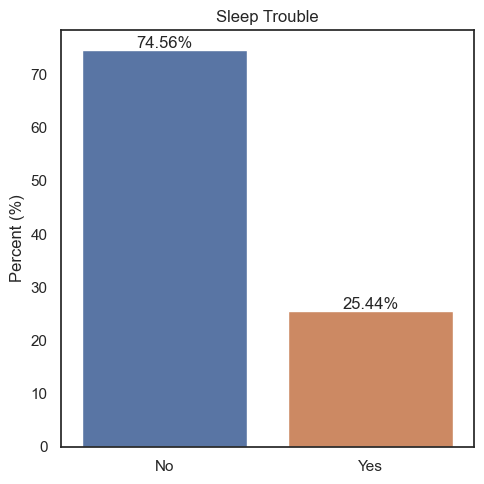

In [16]:
# Perform a normalized value count to obtain the percentage of values in each class
label_counts = df['SleepTrouble'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
label_counts.rename(columns={'index': 'SleepTrouble', 'SleepTrouble': 'Percent'}, inplace=True)
label_counts.sort_values(by='SleepTrouble', inplace=True)

# Visualize results using a bar graph
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x='SleepTrouble', y='Percent', data=label_counts, ax=ax)
ax.set_title('Sleep Trouble')
ax.set_xlabel('')
ax.set_ylabel('Percent (%)')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])
for index, value in enumerate(label_counts['Percent']):
    ax.text(index, value+0.5, f'{round(value, 2)}%', ha='center')

plt.tight_layout()
plt.show()

# Model Building

Before fitting the following models to the data:

- k-nearest neighbors (kNN)
- Naive bayes
- Logistic regression
- Artificial neural network (ANN)
- Decision tree
- Random forest

We begin by benchmarking each model's performance against the null model, which always predicts no `SleepTrouble` (i.e. 0) regardless of input.

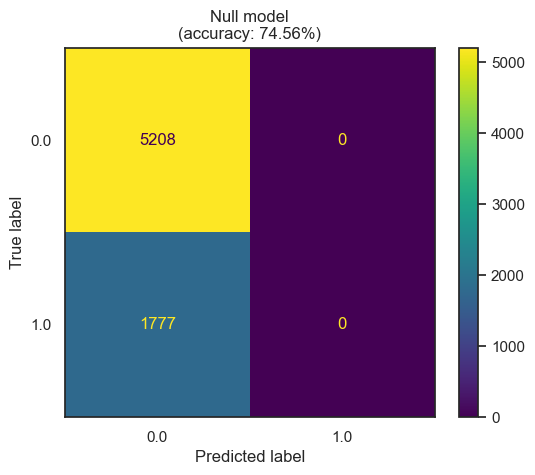

In [17]:
# Split the dataframe into features and labels
X, y = df[['TotChol', 'AvgUrineFlow', 'Diabetes', 'HealthGen']], df['SleepTrouble']

# Define the null model
class null:
    def fit(self, X, y):
        pass
    def predict(self, X):
        return [0] * len(X)
model_0 = null()
    
# Generate predictions
y_pred = model_0.predict(X)
# Compute accuracy
accuracy = accuracy_score(y, y_pred) * 100
# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.title(f'Null model\n(accuracy: {accuracy:.2f}%)')
plt.show()

Thus, the "score-to-beat" is 74.56% accuracy. Proceeding accordingly with the remaining models.

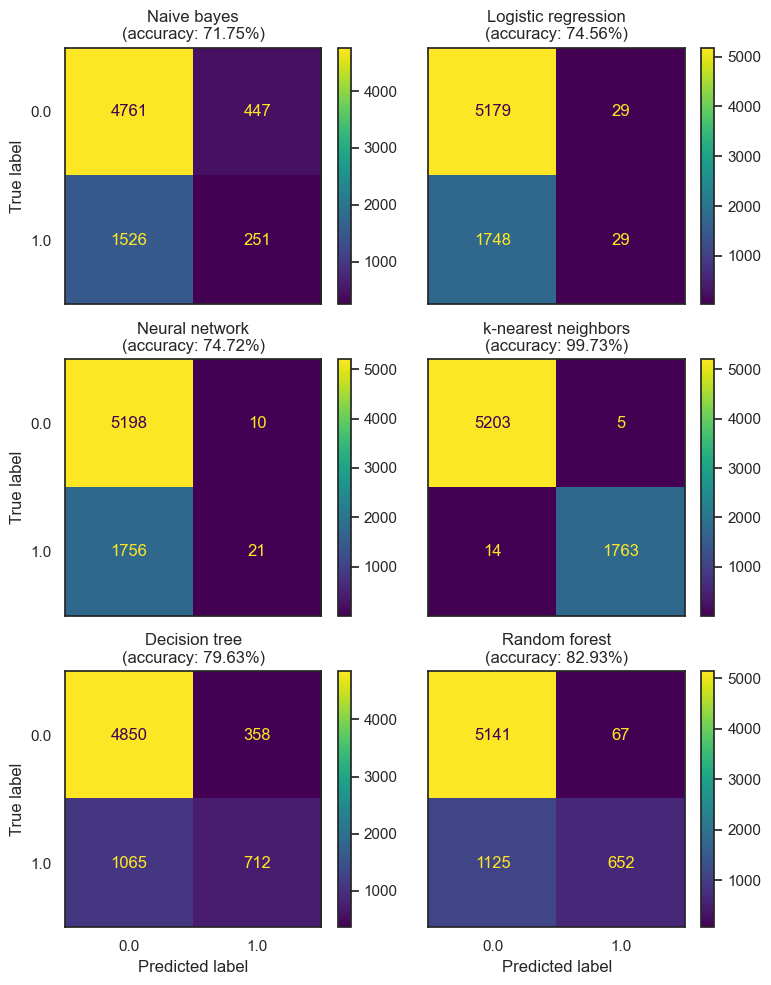

In [18]:
# Define models
models = {
    'Naive bayes': GaussianNB(),
    'Logistic regression': LogisticRegression(random_state=SEED),
    'Neural network': MLPClassifier(hidden_layer_sizes=(256,), random_state=SEED),
    'k-nearest neighbors': KNeighborsClassifier(n_neighbors=16, weights='distance'),
    'Decision tree': DecisionTreeClassifier(min_samples_leaf=16, random_state=SEED),
    'Random forest': RandomForestClassifier(n_estimators=255, min_samples_leaf=8, random_state=SEED)
}

# Create figure
fig, ax = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
ax = ax.flatten()
i = 0

# Loop through each model 
for name, model in models.items():
    # Fit the model to the data
    model.fit(X, y)
    # Generate predictions
    y_pred = model.predict(X)
    # Compute accuracy
    accuracy = accuracy_score(y, y_pred) * 100
    # Visualize confusion matrix
    ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax[i])
    ax[i].set_title(f'{name}\n(accuracy: {accuracy:.2f}%)')
    if i % 2 == 1:
        ax[i].set_ylabel('')
    if i != 4 or i != 5:
        ax[i].set_xlabel('')
    i += 1

ax[4].set_xlabel('Predicted label')
ax[5].set_xlabel('Predicted label')

plt.tight_layout()
plt.show()

Use an ROC curve to further visualize each model's performance. 

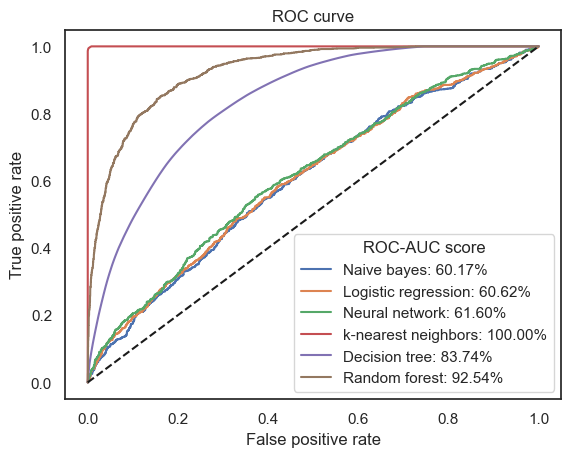

In [19]:
# Loop through each model
for name, model in models.items():
    # Generate predicted probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]
    # Calculate the true-positive and false positive rates
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y, y_pred_proba)
    # Visualize results
    plt.plot(fpr, tpr, label=f'{name}: {roc_auc * 100:.2f}%')

# Customize plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(title='ROC-AUC score', loc='lower right')
plt.show()

Interestingly, we see that the kNN model with `k=16` and a distance-based weighting scheme (`1/d`) vastly outperforms the remaining models (in both accuracy and ROC-AUC). This is unsuprising, since we neither addressed the class imbalance using over- or undersampling, nor did we normalize or rescale the features prior to the training process; indeed, these are all beyond the scope of this assignment. Regardless, let's visualize the feature importances w.r.t. the kNN model using a parallel coordinates plot.

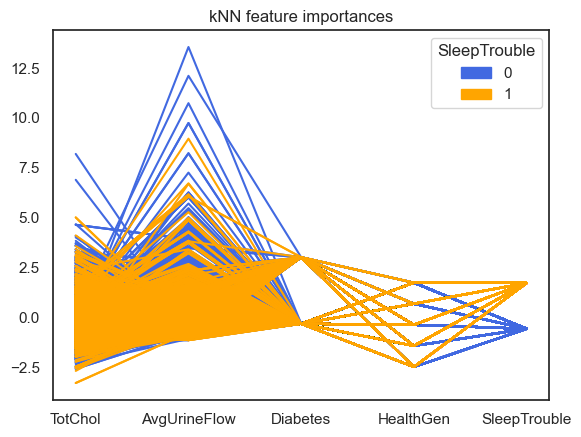

In [20]:
# Normalize the data
df_norm = (df - df.mean()) / df.std()
# Define the color mapping
colors = {0: 'royalblue', 1: 'orange'}
# Create the legend entries with the desired colors
legend_handles = [mpatches.Patch(color=colors[label], label=label) for label in colors]
# Plot the parallel coordinates
fig, ax = plt.subplots()
for label, color in colors.items():
    ax.plot(df_norm.loc[df['SleepTrouble'] == label].values.T, color=color)
ax.set_xticks(range(df_norm.shape[1]))
ax.set_xticklabels(df_norm.columns)
plt.legend(title='SleepTrouble', handles=legend_handles, loc='best')
plt.title('kNN feature importances')
plt.show()

Separating the data by class for clarity.

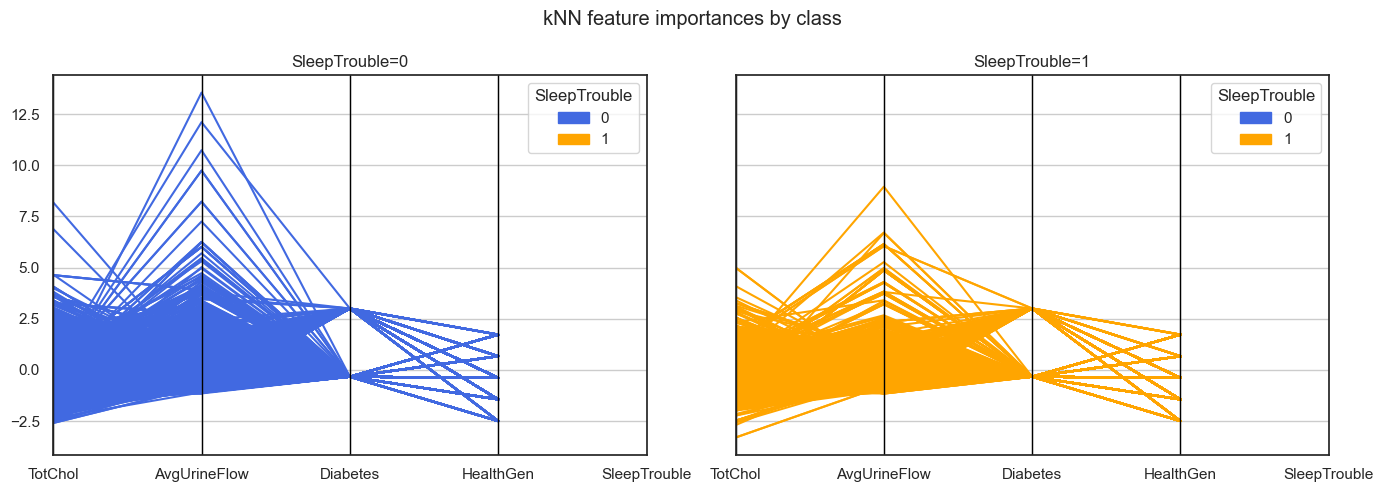

In [21]:
# Create subplots for each class
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# Plot each class in a separate subplot
for label, ax in zip(colors, axes.flatten()):
    pd.plotting.parallel_coordinates(df_norm.loc[df['SleepTrouble'] == label], 'SleepTrouble', color=colors[label], ax=ax)
    ax.set_title(f'SleepTrouble={label}')
    ax.set_xticks(range(df_norm.shape[1]))
    ax.set_xticklabels(df_norm.columns)
# Add the legend to each subplot
axes[0].legend(title='SleepTrouble', handles=legend_handles, loc='best')
axes[1].legend(title='SleepTrouble', handles=legend_handles, loc='best')
fig.suptitle('kNN feature importances by class')
plt.tight_layout()
plt.show()

As expected, we find that higher values of `TotChol` and `AvgUrineFlow` inform the model that the data likely belongs to `SleepTrouble=0`; conversely, `Diabetes` and `HealthGen` don't seem to be contributing much to the model's decision making process. It'd be a logical next step to retrain the model using data that's scaled appropriately for more informative insights. 

Due to time restrictions, we won't explore the remaining model's interpretations. 

# Quantitative Response

Now, we repeat the process all over again, this time with `SleepHrsNight` as our (quantitative) response, using the following models:

- Multiple regression
- Regression tree
- Random forest
- Ridge regression
- Lasso regression

In [22]:
# Read data & drop irrelevant columns
df = pd.read_csv('../data/nhanes_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
# Filter under-16 individuals
df = df[df['Age'] >= 16]
# Only consider health variables
df = df.iloc[:, 33:51]
# Calculate average urine flow rate
df['AvgUrineFlow'] = np.where(df['UrineFlow1'].isnull() & df['UrineFlow2'].isnull(), np.nan,
                        np.where(df['UrineFlow1'].isnull(), df['UrineFlow2'],
                            np.where(df['UrineFlow2'].isnull(), df['UrineFlow1'],
                                (df['UrineFlow1'] + df['UrineFlow2']) / 2
                                    )
                                )
                             )
# Retain only the variables-of-interest
df = df[['TotChol', 'AvgUrineFlow', 'Diabetes', 'HealthGen', 'SleepHrsNight']]
# One-hot encoding
df['Diabetes'] = df['Diabetes'].map({'No': 0, 'Yes': 1})
# Ordinal encoding
df['HealthGen'] = df['HealthGen'].map({'Poor': 1, 'Fair': 2, 'Good': 3, 'Vgood': 4, 'Excellent': 5})
# Impute missing values with 0
df['Diabetes'].fillna(value=0, inplace=True)
# Impute missing values with mean
df['TotChol'] = df['TotChol'].fillna(value=df['TotChol'].mean())
df['SleepHrsNight'] = df['SleepHrsNight'].fillna(value=df['SleepHrsNight'].mean())
# Impute missing values with median
df['AvgUrineFlow'] = df['AvgUrineFlow'].fillna(value=df['AvgUrineFlow'].median())
# Drop rows with missing values
df.dropna(subset=['HealthGen'], inplace=True)
# Reset index
df.reset_index(drop=True, inplace=True)
# Split the dataframe into features and labels
X, y = df[['TotChol', 'AvgUrineFlow', 'Diabetes', 'HealthGen']], df['SleepHrsNight']
# Define the null model
class null:
    def __init__(self, mean):
        self.mean = mean
    def fit(self, X, y):
        pass
    def predict(self, X):
        return [self.mean] * len(X)
model_0 = null(df['SleepHrsNight'].mean())
# Generate predictions
y_pred = model_0.predict(X)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
errors = {'Null model': rmse}
# Print results
print(f'Null model RMSE: {rmse:.4f}')
# Define models
models = {
    'Multiple regression': LinearRegression(),
    'Regression tree': DecisionTreeRegressor(min_samples_leaf=16, random_state=SEED),
    'Random forest': RandomForestRegressor(n_estimators=255, min_samples_leaf=8, random_state=SEED),
    'Ridge regression': Ridge(random_state=SEED),
    'Lasso regression': Lasso(random_state=SEED)
}
# Loop through each model 
for name, model in models.items():
    # Fit the model to the data
    model.fit(X, y)
    # Generate predictions
    y_pred = model.predict(X)
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    errors[name] = rmse
    # Print results
    print(f'{name} RMSE: {rmse:.4f}')

Null model RMSE: 1.3488
Multiple regression RMSE: 1.3343
Regression tree RMSE: 1.1602
Random forest RMSE: 1.0327
Ridge regression RMSE: 1.3343
Lasso regression RMSE: 1.3488


Visualizing the results.

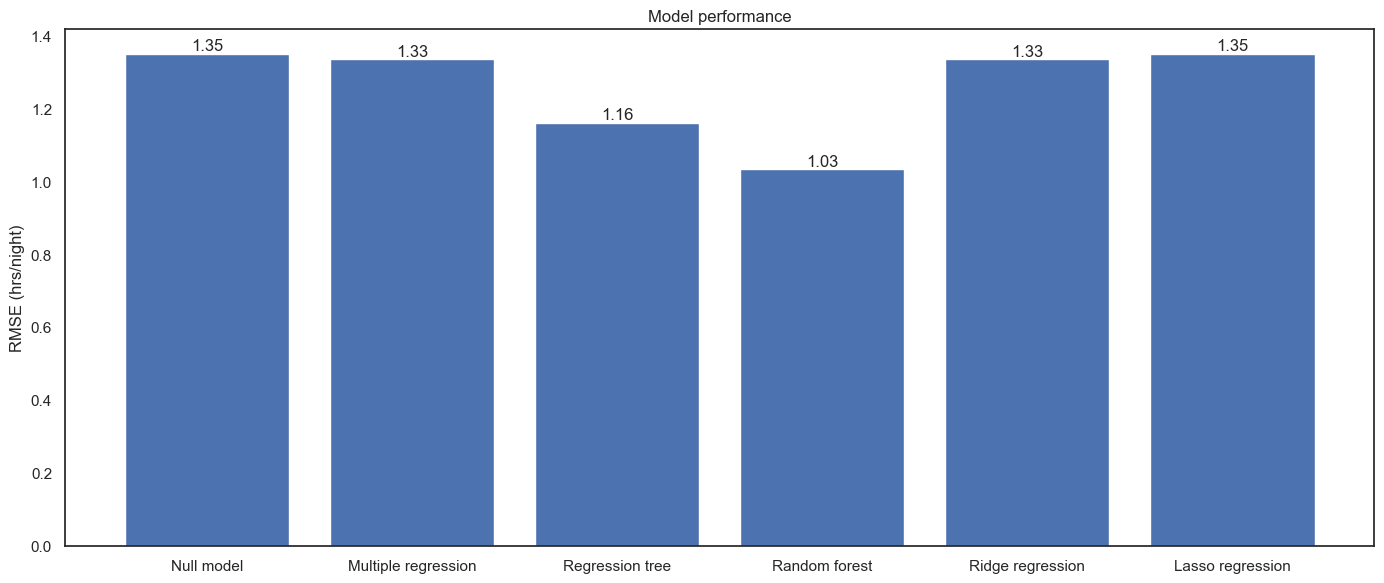

In [23]:
# Create the bar plot
plt.subplots(figsize=(14, 6))
plt.bar(list(errors.keys()), list(errors.values()))
plt.title('Model performance')
plt.ylabel('RMSE (hrs/night)')
# Annotations
i = 0
for error in list(errors.values()):
    plt.text(i, error+0.01, f'{round(error, 2)}', ha='center')
    i += 1

plt.tight_layout()
plt.show()

Hence, we find that the best-performing models are the regression tree and random forest models; their predictions are, on average, 1.16 and 1.03 hrs, respectively, away from the actual value of `SleepHrsNight`. To peek "under the hood", let's create a visualization of the regression tree's structure and split conditions.

In [24]:
# Export regression tree structure into pdf
dot_data = export_graphviz(models['Regression tree'], out_file=None,
                           feature_names=X.columns,  
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('regression_tree')
print(f'See regression_tree.pdf.')

See regression_tree.pdf.


Again, due to time restrictions, we won't delve further into interpreting each model's results from the training phase. 

# Train-Test Split

Repeat the process once more, this time using a train-test split of 75/25.

In [25]:
# Read data & drop irrelevant columns
df = pd.read_csv('../data/nhanes_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
# Filter under-16 individuals
df = df[df['Age'] >= 16]
# Only consider health variables
df = df.iloc[:, 33:51]
# Calculate average urine flow rate
df['AvgUrineFlow'] = np.where(df['UrineFlow1'].isnull() & df['UrineFlow2'].isnull(), np.nan,
                        np.where(df['UrineFlow1'].isnull(), df['UrineFlow2'],
                            np.where(df['UrineFlow2'].isnull(), df['UrineFlow1'],
                                (df['UrineFlow1'] + df['UrineFlow2']) / 2
                                    )
                                )
                             )
# Retain only the variables-of-interest
df = df[['TotChol', 'AvgUrineFlow', 'Diabetes', 'HealthGen', 'SleepHrsNight']]
# One-hot encoding
df['Diabetes'] = df['Diabetes'].map({'No': 0, 'Yes': 1})
# Ordinal encoding
df['HealthGen'] = df['HealthGen'].map({'Poor': 1, 'Fair': 2, 'Good': 3, 'Vgood': 4, 'Excellent': 5})
# Impute missing values with 0
df['Diabetes'].fillna(value=0, inplace=True)
# Impute missing values with mean
df['TotChol'] = df['TotChol'].fillna(value=df['TotChol'].mean())
df['SleepHrsNight'] = df['SleepHrsNight'].fillna(value=df['SleepHrsNight'].mean())
# Impute missing values with median
df['AvgUrineFlow'] = df['AvgUrineFlow'].fillna(value=df['AvgUrineFlow'].median())
# Drop rows with missing values
df.dropna(subset=['HealthGen'], inplace=True)
# Reset index
df.reset_index(drop=True, inplace=True)
# Split the dataframe into features and labels
X, y = df[['TotChol', 'AvgUrineFlow', 'Diabetes', 'HealthGen']], df['SleepHrsNight']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
# Define the null model
class null:
    def __init__(self, mean):
        self.mean = mean
    def fit(self, X, y):
        pass
    def predict(self, X):
        return [self.mean] * len(X)
model_0 = null(y_train.mean())
# Generate predictions
y_pred = model_0.predict(X_test)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
errors = {'Null model': rmse}
# Print results
print(f'Null model RMSE: {rmse:.4f}')
# Define models
models = {
    'Multiple regression': LinearRegression(),
    'Regression tree': DecisionTreeRegressor(min_samples_leaf=16, random_state=SEED),
    'Random forest': RandomForestRegressor(n_estimators=255, min_samples_leaf=8, random_state=SEED),
    'Ridge regression': Ridge(random_state=SEED),
    'Lasso regression': Lasso(random_state=SEED)
}
# Loop through each model 
for name, model in models.items():
    # Fit the model to the data
    model.fit(X_train, y_train)
    # Generate predictions
    y_pred = model.predict(X_test)
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    errors[name] = rmse
    # Print results
    print(f'{name} RMSE: {rmse:.4f}')

Null model RMSE: 1.3624
Multiple regression RMSE: 1.3547
Regression tree RMSE: 1.3664
Random forest RMSE: 1.2820
Ridge regression RMSE: 1.3547
Lasso regression RMSE: 1.3624


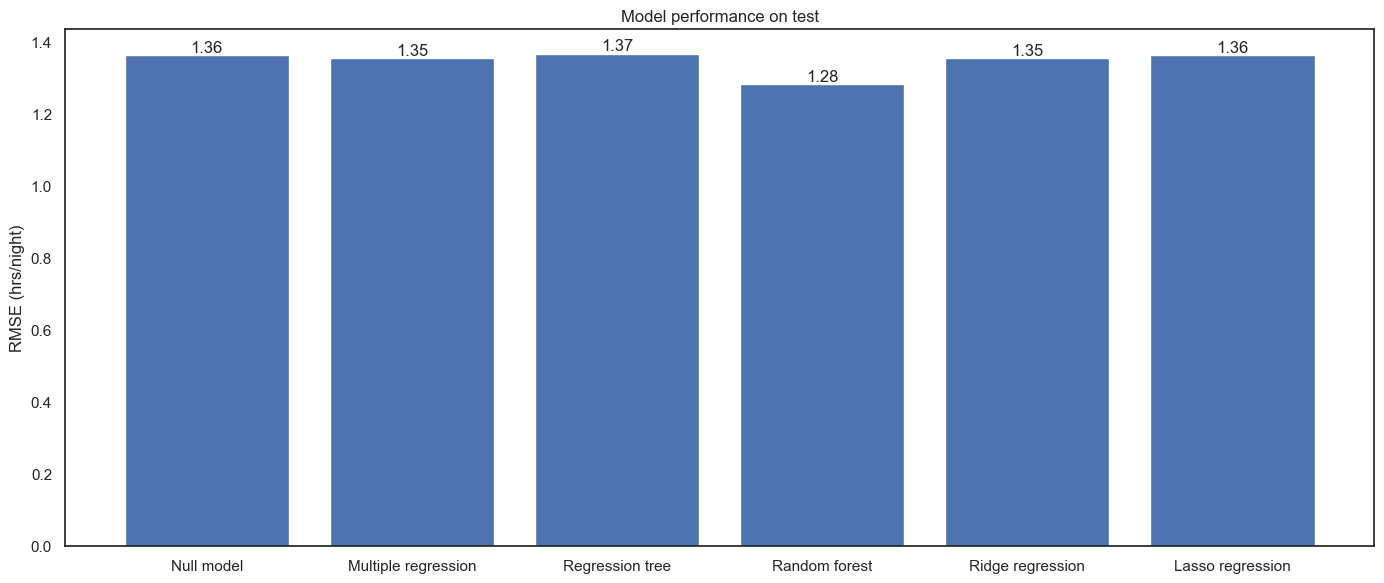

In [26]:
# Create the bar plot
plt.subplots(figsize=(14, 6))
plt.bar(list(errors.keys()), list(errors.values()))
plt.title('Model performance on test')
plt.ylabel('RMSE (hrs/night)')
# Annotations
i = 0
for error in list(errors.values()):
    plt.text(i, error+0.01, f'{round(error, 2)}', ha='center')
    i += 1

plt.tight_layout()
plt.show()

As we can see, errors on `test` are up across the board, w.r.t. the errors on all available data we saw previously. This is to be expected, since when making predictions on data the model's already seen (i.e. been trained on), one would expect more accurate predictions; the real question is whether the model is able to generalize its results to data it's yet to see (e.g. the `test` set). Curiously, the random forest regressor remains the best-performing model, generating predictions that are, on average, 1.28 hrs away from the observed `SleepHrsNight` values in `test`. 

Once again, in the interest of time, we'll stop our discussions here. Part (d) follows the same logic as in all 3 cases thus far.